# Proyek Klasifikasi Gambar: Fruit-360 Dataset
- **Nama:** Hussain Tamam Gucci Al Fauzan
- **Email:** tamam.alfauzan@gmail.com
- **ID Dicoding:** [Input Username]

Dataset yang digunakan adalah **[Fruit-360 Dataset](https://www.kaggle.com/datasets/moltean/fruits)**, yang merupakan kumpulan gambar dari berbagai jenis buah-buahan.  
Gambar-gambar dalam dataset ini diambil dari berbagai sudut, dengan variasi ukuran, serta mencakup kondisi buah yang berbeda seperti matang dan busuk.


## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs kaggle opencv-python tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [9]:
import numpy as np
import pandas as pd
import cv2
import PIL
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflowjs
import sklearn
import tqdm
import shutil
from pathlib import Path

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tamhusthtg","key":"ebb51b1b0d300419a4c4cad839e70a87"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!pip install kaggle

## Data Preparation

### Data Loading

In [6]:
!kaggle datasets download -d moltean/fruits

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0


In [7]:
# Ekstrak dataset
!unzip -o fruits.zip -d fruits_dataset


Streaming output truncated to the last 5000 lines.
  inflating: fruits_dataset/fruits-360_original-size/fruits-360-original-size/Validation/Quince 3/r1_317.jpg  
  inflating: fruits_dataset/fruits-360_original-size/fruits-360-original-size/Validation/Quince 3/r1_321.jpg  
  inflating: fruits_dataset/fruits-360_original-size/fruits-360-original-size/Validation/Quince 3/r1_33.jpg  
  inflating: fruits_dataset/fruits-360_original-size/fruits-360-original-size/Validation/Quince 3/r1_37.jpg  
  inflating: fruits_dataset/fruits-360_original-size/fruits-360-original-size/Validation/Quince 3/r1_41.jpg  
  inflating: fruits_dataset/fruits-360_original-size/fruits-360-original-size/Validation/Quince 3/r1_45.jpg  
  inflating: fruits_dataset/fruits-360_original-size/fruits-360-original-size/Validation/Quince 3/r1_49.jpg  
  inflating: fruits_dataset/fruits-360_original-size/fruits-360-original-size/Validation/Quince 3/r1_5.jpg  
  inflating: fruits_dataset/fruits-360_original-size/fruits-360-orig

In [8]:
dataset_path = '/content/fruits_dataset'
print(os.listdir(dataset_path))

['fruits-360_original-size', 'fruits-360_100x100', 'fruits-360_dataset_meta', 'fruits-360_multi']


In [13]:
print(os.listdir("/content/fruits_dataset/fruits-360_original-size"))


['fruits-360-original-size', '.ipynb_checkpoints']


### Data Preprocessing

#### Split Dataset

In [14]:
original_path = Path("/content/fruits_dataset/fruits-360_original-size/fruits-360-original-size")
merged_path = Path("/content/fruits_dataset/fruits-360_original-size/fruits-360-original-size-merged")

merged_path.mkdir(exist_ok=True)

# Gabungkan Training dan Test
for split in ["Training", "Test"]:
    split_path = original_path / split
    for class_dir in split_path.iterdir():
        if class_dir.is_dir():
            target_dir = merged_path / class_dir.name
            target_dir.mkdir(parents=True, exist_ok=True)
            for file in class_dir.iterdir():
                if file.is_file():
                    shutil.copy(file, target_dir / file.name)

In [18]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    merged_path,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(100, 100),
    batch_size=32,
    label_mode='categorical'
)

val_test_dataset = tf.keras.utils.image_dataset_from_directory(
    merged_path,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(100, 100),
    batch_size=32,
    label_mode='categorical'
)

#Pecah 30% jadi val dan test masing-masing 15%
val_batches = tf.data.experimental.cardinality(val_test_dataset).numpy()
validation_dataset = val_test_dataset.take(val_batches // 2)
test_dataset = val_test_dataset.skip(val_batches // 2)

# Dapatkan class_names
class_names = train_dataset.class_names
print(f"Jumlah kelas: {len(class_names)}")
print("Contoh kelas:", class_names[:5])

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.6, 1.4)
    return image, label
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# --- Prefetch untuk validation dan test dataset ---
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 33001 files belonging to 65 classes.
Using 23101 files for training.
Found 33001 files belonging to 65 classes.
Using 9900 files for validation.
Jumlah kelas: 65
Contoh kelas: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14']


## Modelling

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.GaussianNoise(0.3),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu', padding='same', input_shape=(100, 100, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(65, activation='softmax')
])


# Kompilasi model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_2                │ ?                      │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

callbacks=[early_stopping, reduce_lr]


In [33]:
# Latih model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks = callbacks
    )

Epoch 1/20
722/722 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - accuracy: 0.1224 - loss: 4.4082 - val_accuracy: 0.7718 - val_loss: 1.1546 - learning_rate: 0.0010
Epoch 2/20
722/722 ━━━━━━━━━━━━━━━━━━━━ 73s 18ms/step - accuracy: 0.5146 - loss: 1.8432 - val_accuracy: 0.8948 - val_loss: 0.7284 - learning_rate: 0.0010
Epoch 3/20
722/722 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - accuracy: 0.6591 - loss: 1.3419 - val_accuracy: 0.9151 - val_loss: 0.6151 - learning_rate: 0.0010
Epoch 4/20
722/722 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.7189 - loss: 1.1276 - val_accuracy: 0.9212 - val_loss: 0.5608 - learning_rate: 0.0010
Epoch 5/20
722/722 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.7765 - loss: 0.9552 - val_accuracy: 0.9296 - val_loss: 0.5092 - learning_rate: 0.0010
Epoch 6/20
722/722 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.7982 - loss: 0.9122 - val_accuracy: 0.9651 - val_loss: 0.4534 - learning_rate: 0.0010
Epoch 7/20
722/722 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.8107 - l

## Evaluasi dan Visualisasi

In [34]:
# Evaluasi model pada test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"\nEvaluasi Model pada Test Set:")
print(f"Akurasi: {test_accuracy*100:.2f}%")
print(f"Loss: {test_loss:.4f}")

155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.9778 - loss: 0.4077

Evaluasi Model pada Test Set:
Akurasi: 97.83%
Loss: 0.4080


In [35]:
# Prediksi kelas pada test set
y_true = []
y_pred = []
for images, labels in test_dataset:
    predictions = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Hitung metrik tambahan
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\nMetrik Evaluasi Detail:")
print(f"Precision (weighted): {precision*100:.2f}%")
print(f"Recall (weighted): {recall*100:.2f}%")
print(f"F1-Score (weighted): {f1*100:.2f}%")


Metrik Evaluasi Detail:
Precision (weighted): 97.93%
Recall (weighted): 97.77%
F1-Score (weighted): 97.72%


Model mampu memprediksi secara stabil dan tidak bias ke kelas tertentu yang dimana dapat terlihat bahwa loss yang berada di 0.407(meski masih tergolong tinggi).

Hasil

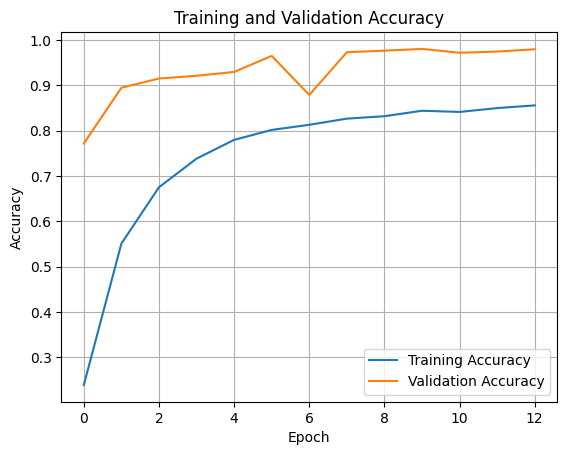

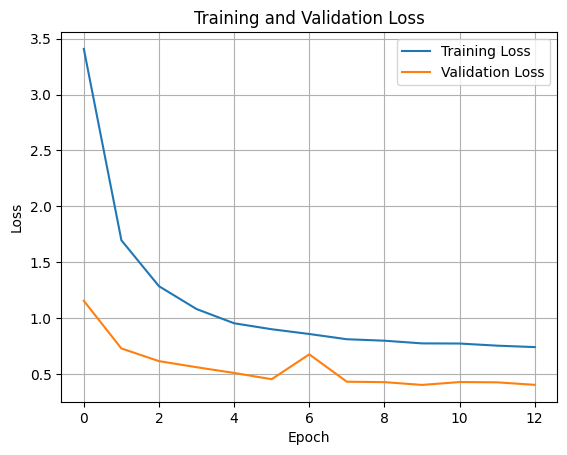

In [36]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


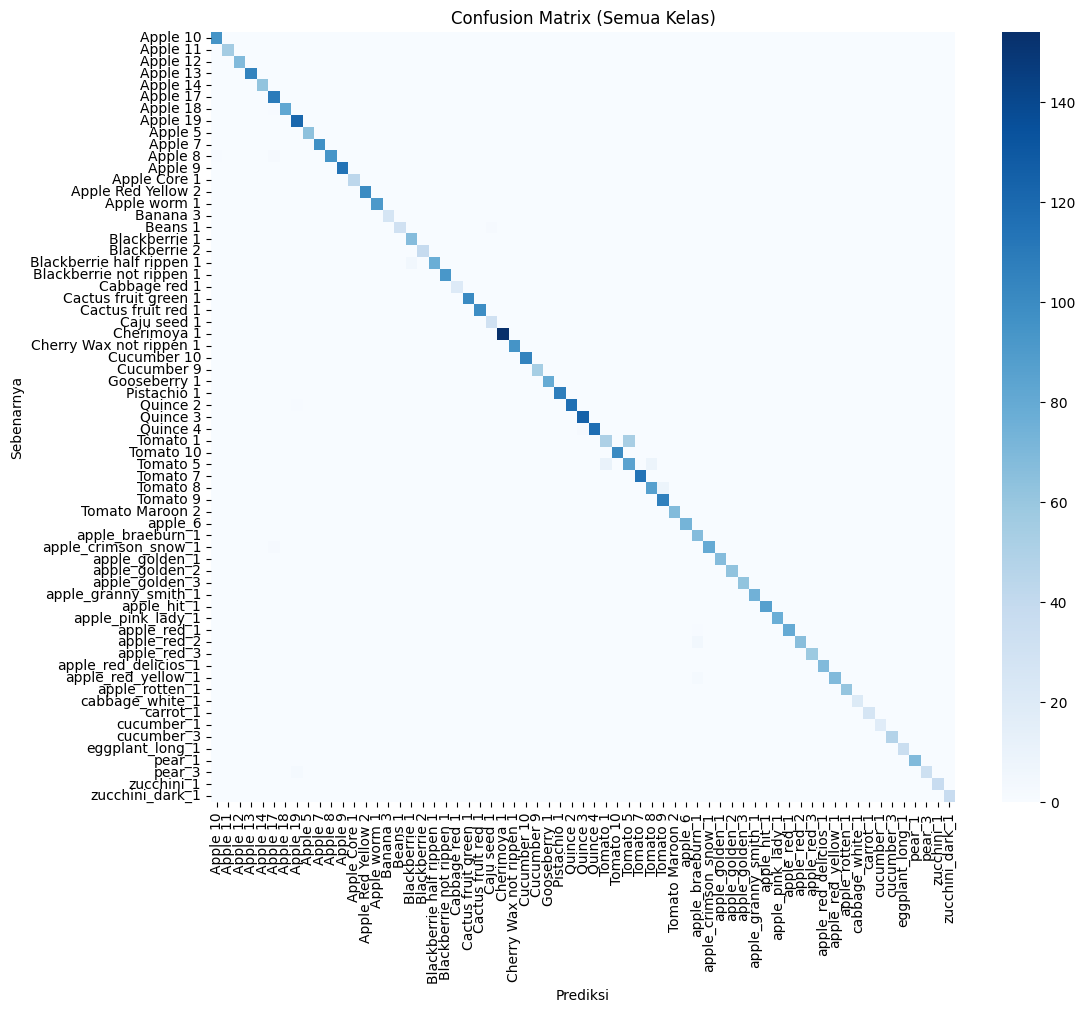

In [37]:
# Confusion matrix (semua kelas)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Semua Kelas)')
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

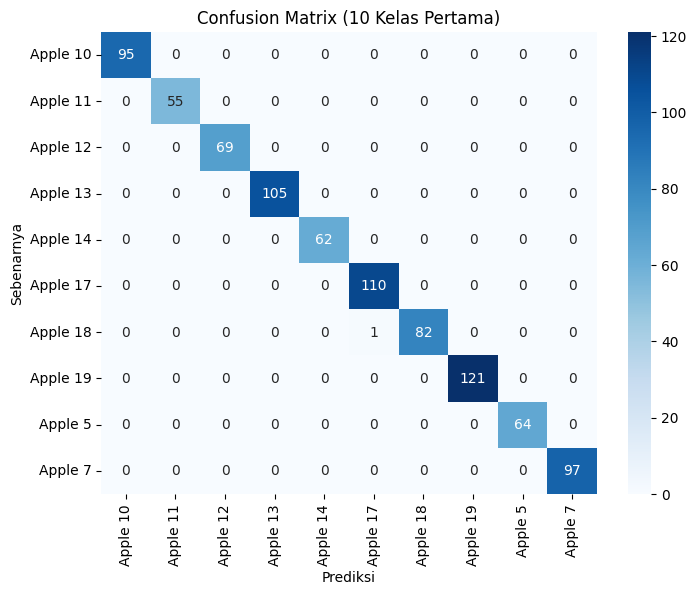

In [38]:
# Confusion matrix untuk 10 kelas pertama
cm_subset = cm[:10, :10]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues', xticklabels=class_names[:10], yticklabels=class_names[:10])
plt.title('Confusion Matrix (10 Kelas Pertama)')
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.show()

In [39]:
# Analisis kesalahan
print("\nKelas dengan Kesalahan Terbanyak:")
errors = []
for i in range(len(class_names)):
    false_positives = sum(cm[:, i]) - cm[i, i]
    false_negatives = sum(cm[i, :]) - cm[i, i]
    total_errors = false_positives + false_negatives
    if total_errors > 0:
        errors.append((class_names[i], total_errors))

errors.sort(key=lambda x: x[1], reverse=True)
for class_name, error_count in errors[:5]:
    print(f"Kelas: {class_name}, Jumlah kesalahan: {error_count}")


Kelas dengan Kesalahan Terbanyak:
Kelas: Tomato 5, Jumlah kesalahan: 73
Kelas: Tomato 1, Jumlah kesalahan: 64
Kelas: Tomato 8, Jumlah kesalahan: 18
Kelas: Tomato 9, Jumlah kesalahan: 9
Kelas: apple_braeburn_1, Jumlah kesalahan: 9


terlihat bahwa beberapa prediksi masih menimbulkan kesalahan dalam mengklasifikasi. hal ini disebabkan beberapa dataset memang memiliki kemiripan

## Konversi Model

In [40]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_2                │ (None, 100, 100, 3)    │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 100, 100, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100, 100, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 50, 50, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 65)             │         4,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,613 (1.51 MB)

 Trainable params: 131,457 (513.50 KB)

 Non-trainable params: 240 (960.00 B)

 Optimizer params: 262,916 (1.00 MB)

In [41]:
# 1. SavedModel
model.export('submission/saved_model')

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor_39')
Output Type:
  TensorSpec(shape=(None, 65), dtype=tf.float32, name=None)
Captures:
  134246182305424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134246182294864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134246182299280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134246182295632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134246182299664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134246182298512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134246182297360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134246182294672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134246182303504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134246182302160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1342

In [42]:
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('submission/saved_model')
tflite_model = converter.convert()

# Simpan .tflite
os.makedirs('submission/tflite', exist_ok=True)
with open('submission/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Simpan label.txt
with open('submission/tflite/label.txt', 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")

In [44]:
# Export ke folder tfjs/
!tensorflowjs_converter \
  --input_format=tf_saved_model \
  --output_format=tfjs_graph_model \
  submission/saved_model \
  submission/tfjs_model

2025-04-19 17:34:17.746496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745084057.780713   22693 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745084057.791575   22693 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-19 17:34:22.505561: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745084062.505745   22693 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference (Optional)